In [1]:
import os
os.chdir('../')
import time
#time.sleep(100*60)
import matplotlib.pyplot as plt 
import os
import torch
import numpy as np
import torch.nn as nn
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
import random 
from decimal import Decimal
import warnings
import torch.nn.functional as F
from functools import partial
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from ultils.deepwave_fp import Physics_deepwave
from parameters_efwi import *
from ultils.utils import *

The number of available GPUs is: 1
The selected GPU device is: NVIDIA GeForce RTX 3090
NT: 800
offsetx: 8020
depth: 2560
N_RECEIVERS: 375


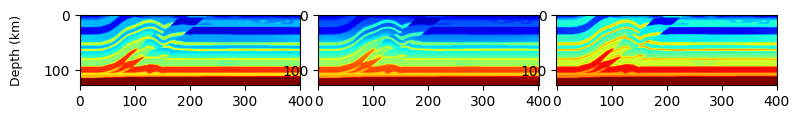

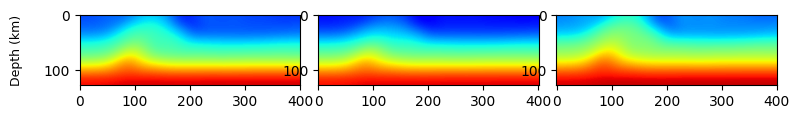

In [2]:
vp_true,vs_true,rho_true = load_true_models(path_vp_true, path_vs_true, path_rho_true)
vp_true,vs_true,rho_true = vp_true.to(DEVICE), vs_true.to(DEVICE), rho_true.to(DEVICE)
fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig1 = ax[0].imshow(vp_true.cpu().numpy(), cmap= 'jet',vmin = vp_true.min(),vmax = vp_true.max())
ax[0].set_ylabel("Depth (km)\n",fontsize=9)
fig2 = ax[1].imshow(vs_true.cpu().numpy(), cmap= 'jet',vmin = vs_true.min(),vmax = vs_true.max())
fig3 = ax[2].imshow(rho_true.cpu().numpy(), cmap= 'jet',vmin = rho_true.min(),vmax = rho_true.max())
plt.subplots_adjust(hspace=-0.84,wspace=0.08) 
plt.show()

vp_initial, vs_initial, rho_initial = load_init_models(path_vp_init,path_vs_init,path_rho_init)

fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig1 = ax[0].imshow(vp_initial.cpu().numpy(), cmap= 'jet',vmin = vp_true.min(),vmax = vp_true.max())
ax[0].set_ylabel("Depth (km)\n",fontsize=9)
fig2 = ax[1].imshow(vs_initial.cpu().numpy(), cmap= 'jet',vmin = vs_true.min(),vmax = vs_true.max())
fig3 = ax[2].imshow(rho_initial.cpu().numpy(), cmap= 'jet',vmin = rho_true.min(),vmax = rho_true.max())
plt.subplots_adjust(hspace=-0.84,wspace=0.08) 
plt.show()


torch.float32
wavelets shape: torch.Size([30, 1, 800])
torch.Size([30, 800, 375])


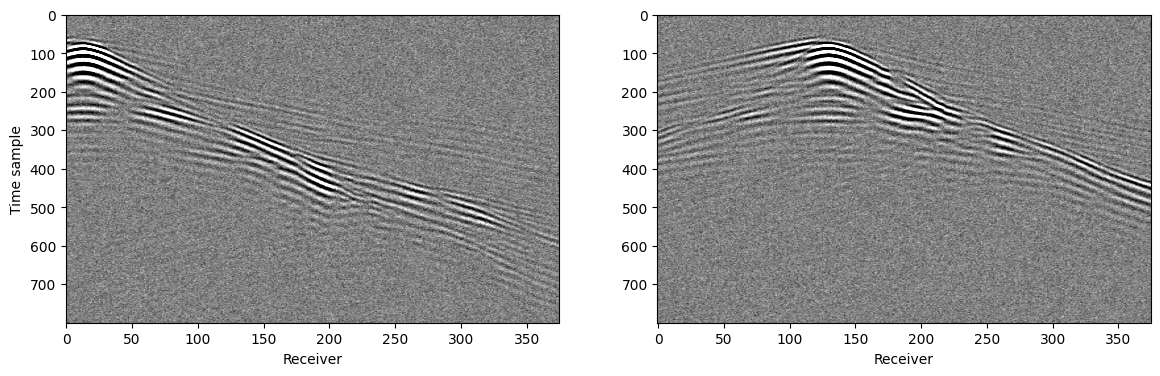

In [3]:
# load obs

# vx= torch.load('./obs_and_model_data/obs_vx.npy')
# vz= torch.load('./obs_and_model_data/obs_vy.npy')

if lack_low_fre == 'yes':
    src_new = seismic_filter(data=src_old.cpu(), \
                           filter_type='highpass',freqmin=cut_freq, \
                           freqmax=None,df=1/DT,corners=16)
    src_new = torch.tensor(src_new).to(torch.float32).to(DEVICE)
else:
    src_new = src_old
src_new = src_new.to(torch.float32).to(DEVICE)
print(src_new.dtype)
#print(vp_true.dtype)
print('wavelets shape:',src_new.shape)

physics = Physics(inpa['dh'], inpa['dt'],inpa['fdom'] ,size=deepwave_size,src=src_new,
                        src_loc=src_loc, rec_loc=rec_loc
                        )
taux_est = physics(vp_true,vs_true,rho_true)  
d_obs_vx = taux_est[0]
d_obs_vy = taux_est[1]


if noise_test == 'yes':
    d_obs_vx = add_gaussian_noise(d_obs_vx,noise_level = noise_level)
    d_obs_vy = add_gaussian_noise(d_obs_vy,noise_level = noise_level)
else:
    d_obs_vx = d_obs_vx
    d_obs_vy = d_obs_vy
    
##### show thses data
d_obs_vx_plot = d_obs_vx.squeeze(0)
d_obs_vy_plot = d_obs_vx.squeeze(0)
print(d_obs_vx_plot.shape)
vmin, vmax = torch.quantile(d_obs_vx_plot[10].to(DEVICE),
                            torch.tensor([0.01, 0.99]).to(DEVICE))
vsmin, vsmax = torch.quantile(d_obs_vy_plot[10].to(DEVICE),
                                 torch.tensor([0.01, 0.99]).to(DEVICE))


fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].imshow(d_obs_vx_plot[1].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vmin, vmax=vmax)
ax[0].set_xlabel("Receiver")
ax[0].set_ylabel("Time sample")
ax[1].imshow(d_obs_vx_plot[10].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vsmin, vmax=vsmax)
ax[1].set_xlabel("Receiver")
# ax[1].set_ylabel("Time sample")
plt.subplots_adjust(hspace=0.6) 
#plt.savefig(Fig_path+f"/obs&input_gather"+".jpg", dpi=900)  
plt.show()

In [4]:
vp_initial = vp_initial.to(DEVICE)
vs_initial = vs_initial.to(DEVICE)
rho_initial = rho_initial.to(DEVICE)
vp = vp_initial.requires_grad_(True)
vs = vs_initial.requires_grad_(True)
rho = rho_initial.requires_grad_(True)


criteria = torch.nn.L1Loss(reduction='sum')

optimer = torch.optim.Adam([{'params': [vp], 'lr': 1.5},
                                            {'params': [vs], 'lr': 1.5},
                                           {'params': [rho], 'lr': 0.5}])

###################################################################
##########                                               ##########
##########             EFWI WITH ADAM IS RUNNING         ##########
##########                                               ##########
##########                                               ##########
###################################################################
Iteration 20 = loss: 3101220.2500,model loss: 28487795.2500,time:5.40,snr_vp:20.876,snr_vs:20.717,snr_rho:31.804
Iteration 40 = loss: 2940463.2500,model loss: 27034059.0000,time:5.53,snr_vp:21.343,snr_vs:20.833,snr_rho:31.179


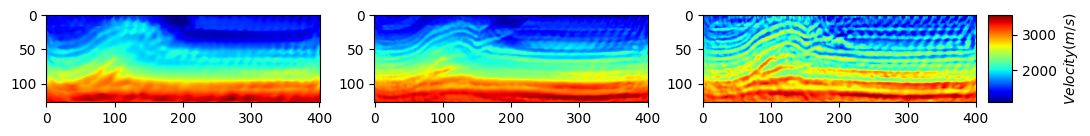

Iteration 60 = loss: 2880941.5000,model loss: 25915795.5000,time:5.39,snr_vp:21.742,snr_vs:20.888,snr_rho:30.648
Iteration 80 = loss: 2853686.2500,model loss: 25016552.0000,time:5.40,snr_vp:22.050,snr_vs:20.928,snr_rho:30.292
Iteration 100 = loss: 2840838.5000,model loss: 24347834.0000,time:5.39,snr_vp:22.269,snr_vs:20.941,snr_rho:30.036


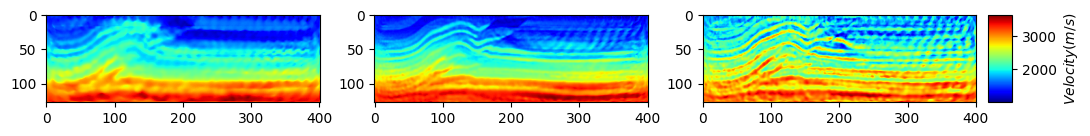

Iteration 120 = loss: 2833880.7500,model loss: 23893023.5000,time:5.40,snr_vp:22.413,snr_vs:20.936,snr_rho:29.822
Iteration 140 = loss: 2829205.7500,model loss: 23600972.5000,time:5.42,snr_vp:22.500,snr_vs:20.915,snr_rho:29.609


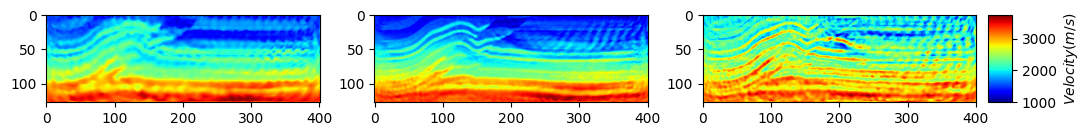

Iteration 160 = loss: 2825649.0000,model loss: 23429513.0000,time:5.40,snr_vp:22.544,snr_vs:20.887,snr_rho:29.390
Iteration 180 = loss: 2822785.2500,model loss: 23355976.5000,time:6.24,snr_vp:22.555,snr_vs:20.852,snr_rho:29.163
Iteration 200 = loss: 2820435.5000,model loss: 23354954.2500,time:6.25,snr_vp:22.539,snr_vs:20.811,snr_rho:28.932


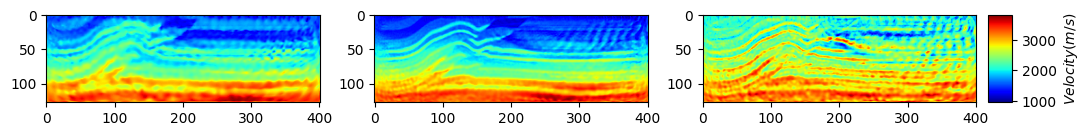

Iteration 220 = loss: 2818485.7500,model loss: 23416630.0000,time:6.25,snr_vp:22.498,snr_vs:20.767,snr_rho:28.697
Iteration 240 = loss: 2816799.2500,model loss: 23528964.0000,time:6.25,snr_vp:22.439,snr_vs:20.720,snr_rho:28.465


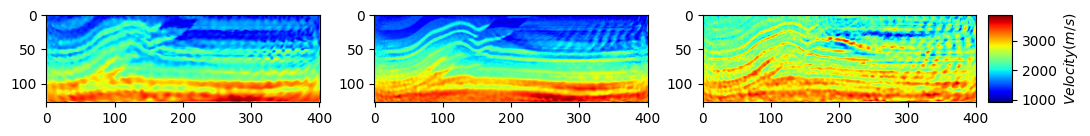

Iteration 260 = loss: 2815256.7500,model loss: 23674448.5000,time:6.25,snr_vp:22.363,snr_vs:20.672,snr_rho:28.237
Iteration 280 = loss: 2813879.5000,model loss: 23850203.5000,time:6.25,snr_vp:22.274,snr_vs:20.623,snr_rho:28.016
Iteration 300 = loss: 2812599.7500,model loss: 24046325.7500,time:6.25,snr_vp:22.178,snr_vs:20.574,snr_rho:27.801


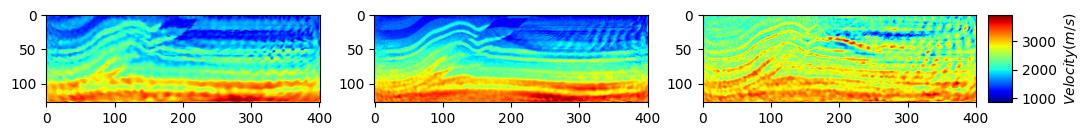

Iteration 320 = loss: 2811374.0000,model loss: 24257422.5000,time:6.29,snr_vp:22.074,snr_vs:20.524,snr_rho:27.596
Iteration 340 = loss: 2810157.0000,model loss: 24477018.7500,time:6.32,snr_vp:21.966,snr_vs:20.473,snr_rho:27.400


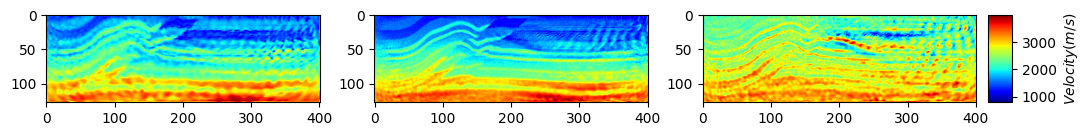

Iteration 360 = loss: 2808977.0000,model loss: 24705529.0000,time:6.25,snr_vp:21.854,snr_vs:20.422,snr_rho:27.212
Iteration 380 = loss: 2807783.2500,model loss: 24941406.7500,time:6.24,snr_vp:21.739,snr_vs:20.371,snr_rho:27.030
Iteration 400 = loss: 2806565.5000,model loss: 25181701.0000,time:6.25,snr_vp:21.624,snr_vs:20.323,snr_rho:26.857


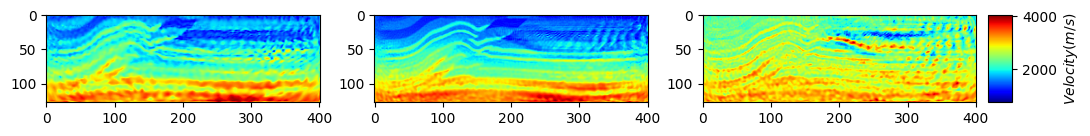

Iteration 420 = loss: 2805355.2500,model loss: 25424937.2500,time:6.25,snr_vp:21.509,snr_vs:20.275,snr_rho:26.692
Iteration 440 = loss: 2804204.0000,model loss: 25666192.5000,time:6.29,snr_vp:21.396,snr_vs:20.229,snr_rho:26.536


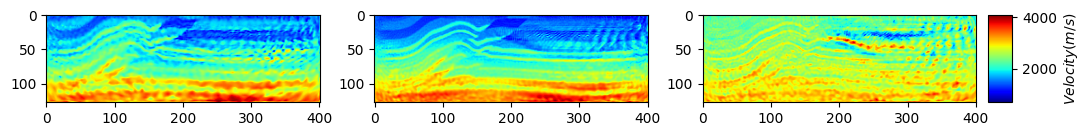

Iteration 460 = loss: 2803081.7500,model loss: 25906729.5000,time:6.18,snr_vp:21.282,snr_vs:20.186,snr_rho:26.387
Iteration 480 = loss: 2802019.5000,model loss: 26142307.0000,time:6.19,snr_vp:21.172,snr_vs:20.146,snr_rho:26.245
Iteration 500 = loss: 2800975.2500,model loss: 26378191.0000,time:6.19,snr_vp:21.062,snr_vs:20.109,snr_rho:26.111


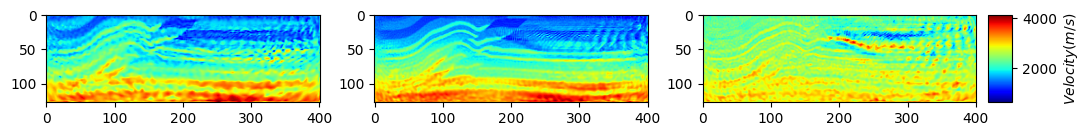

Iteration 520 = loss: 2800017.7500,model loss: 26612651.0000,time:6.19,snr_vp:20.953,snr_vs:20.073,snr_rho:25.981
Iteration 540 = loss: 2799123.2500,model loss: 26846345.0000,time:6.19,snr_vp:20.846,snr_vs:20.037,snr_rho:25.857


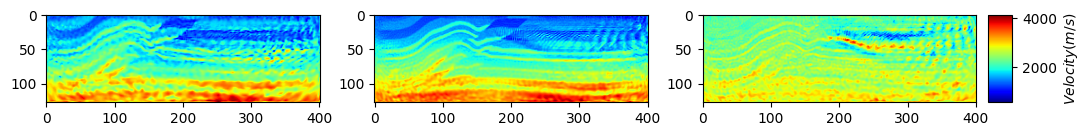

Iteration 560 = loss: 2798277.5000,model loss: 27076893.0000,time:6.19,snr_vp:20.743,snr_vs:20.003,snr_rho:25.738
Iteration 580 = loss: 2797466.7500,model loss: 27307972.0000,time:6.18,snr_vp:20.642,snr_vs:19.970,snr_rho:25.623
Iteration 600 = loss: 2796706.7500,model loss: 27534987.2500,time:6.19,snr_vp:20.544,snr_vs:19.939,snr_rho:25.512


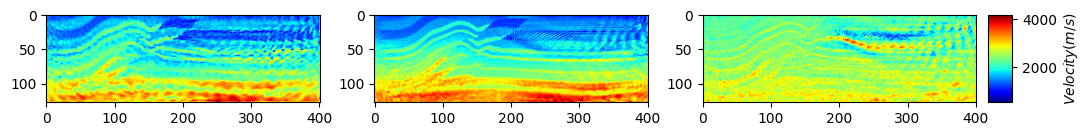

Running complete in 61m  9s


In [5]:
### efwi loop

print("###################################################################")
print("##########                                               ##########")
print("##########             EFWI WITH ADAM IS RUNNING         ##########")
print("##########                                               ##########")
print("##########                                               ##########")
print("###################################################################")
t_start = time.time()

for iter in range(total_iter):
    loss_data_minibatch = []
    time_each_bath_start = time.time()
    for batch in range(mini_batches):
        loss_freqs = []
       
        optimer.zero_grad()
        
        src_loc_batch = src_loc[batch::mini_batches].to(DEVICE)
        rec_loc_batch = rec_loc[batch::mini_batches].to(DEVICE)
        src_batch = src_new[batch::mini_batches].to(DEVICE)
                
        physics = Physics(inpa['dh'], inpa['dt'],inpa['fdom'] ,size=deepwave_size,src=src_batch,
                        src_loc=src_loc_batch, rec_loc=rec_loc_batch
                        )
       
        vp = vp.to(DEVICE)
        vs = vs.to(DEVICE)
        rho = rho.to(DEVICE)
    
        taux_est = physics(vp,vs,rho) 
        taux_vx_est_filtered = taux_est[0].to(DEVICE)
        taux_vy_est_filtered = taux_est[1].to(DEVICE)
 
        taux_est_all = torch.cat((taux_vx_est_filtered,taux_vy_est_filtered),dim=1).to(DEVICE)
        
        d_obs_vx_filtered = d_obs_vx[:, batch::mini_batches].to(DEVICE)
        d_obs_vy_filtered = d_obs_vy[:, batch::mini_batches].to(DEVICE)
        d_obs_filtered_all = torch.cat((d_obs_vx_filtered,d_obs_vy_filtered),dim=1).to(DEVICE)

        loss_data = 1.0e8*criteria(taux_est_all, d_obs_filtered_all)#+tikhLoss# +(1-weight)*tikhLoss+weight*tvloss
        loss = loss_data   
        loss.backward()
        optimer.step()
        loss_freqs.append(loss_data.cpu().detach().numpy())
        loss_data_minibatch.append(np.mean(loss_freqs))
    all_loss_data.append(loss_data) 
    time_each_bath_end = time.time()
    time_each_iter.append(time_each_bath_end - time_each_bath_start)

    with torch.no_grad():
        all_loss_vx_model.append(
            criteria(vp.cpu(),vp_true.cpu()).detach().numpy().item()
        )
        
        all_loss_vy_model.append(
            criteria(vs.cpu(),vs_true.cpu()).detach().numpy().item()
        )
        all_loss_rho_model.append(
            criteria(rho.cpu(),rho_true.cpu()).detach().numpy().item()
        )
        all_loss_model.append(
            criteria(vp, vp_true).item()+ criteria(vs, vs_true).item()+ criteria(rho, rho_true).item()
        )
    
    snr_vp = ComputeSNR(vp.detach().cpu().numpy(), \
                  vp_true.detach().cpu().numpy())
    SNR_vp = np.append(SNR_vp, snr_vp)
    snr_vs = ComputeSNR(vs.detach().cpu().numpy(), \
                  vs_true.detach().cpu().numpy())
    SNR_vs = np.append(SNR_vs, snr_vs)
    snr_rho = ComputeSNR(rho.detach().cpu().numpy(), \
                  rho_true.detach().cpu().numpy())
    SNR_rho = np.append(SNR_rho, snr_rho)
 
    ssim_vp = ComputeSSIM(vp.detach().cpu().numpy(), \
                  vp_true.detach().cpu().numpy())
    SSIM_vp = np.append(SSIM_vp, ssim_vp)
    ssim_vs = ComputeSSIM(vs.detach().cpu().numpy(), \
                  vs_true.detach().cpu().numpy())
    SSIM_vs = np.append(SSIM_vs, ssim_vs)
    ssim_rho = ComputeSSIM(rho.detach().cpu().numpy(), \
                  rho_true.detach().cpu().numpy())
    SSIM_rho = np.append(SSIM_rho, ssim_rho)

    rerror_vp = ComputeRE(vp.detach().cpu().numpy(), \
                  vp_true.detach().cpu().numpy())
    ERROR_vp = np.append(ERROR_vp, rerror_vp)
    rerror_vs = ComputeRE(vs.detach().cpu().numpy(), \
                  vs_true.detach().cpu().numpy())
    ERROR_vs = np.append(ERROR_vs, rerror_vs)
    rerror_rho = ComputeRE(rho.detach().cpu().numpy(), \
                  rho_true.detach().cpu().numpy())
    ERROR_rho = np.append(ERROR_rho, rerror_rho)   
    
    if (iter+1)%20 == 0:
        # print(f"Iteration {iter + 1}, loss: {all_loss_data[-1]},model loss:{all_loss_model[-1]},tvnorm:{tvloss},tinorm:{tikhLoss}")
        print(f"Iteration {iter + 1} = loss: {all_loss_data[-1]:.4f},model loss: {all_loss_model[-1]:.4f},time:{time_each_iter[-1]:.2f},snr_vp:{SNR_vp[-1]:.3f},snr_vs:{SNR_vs[-1]:.3f},snr_rho:{SNR_rho[-1]:.3f}")
        
    if (iter+1)%50 == 0:
        np.save(vp_save_path + 'recx_iter_%s.npy' %(iter+1), vp.cpu().detach().numpy(), 2)
        np.save(vs_save_path + 'recx_iter_%s.npy' %(iter+1), vs.cpu().detach().numpy(), 2)
        np.save(rho_save_path + 'recx_iter_%s.npy' %(iter+1), rho.cpu().detach().numpy(), 2)
        fig, ax = plt.subplots(1,3,figsize=(12, 6))
        im0 = ax[0].imshow(vp.squeeze(0).detach().cpu(), 
                          cmap="jet") 
        im1 = ax[1].imshow(vs.squeeze(0).detach().cpu(), 
                          cmap="jet") 
        im2 = ax[2].imshow(rho.squeeze(0).detach().cpu(), 
                          cmap="jet") 
        points = ax[1].get_position().get_points()
        dy = points[1, 1] - points[0, 1]

        cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
        cax.yaxis.set_ticks_position("right")
        cbar = fig.colorbar(im1, cax=cax, orientation="vertical", 
                            extend="neither", label="$Velocity (m/s)$"
                            )
        plt.show()
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))


In [6]:
#### save log_data

with torch.no_grad():
    #print(all_loss_data)
     
    
    
    all_loss_data_save = np.array([tensor.cpu().numpy() for tensor in all_loss_data])
    np.savetxt(main_path+'all_loss_data.txt', all_loss_data_save,delimiter=',')
    
    np.savetxt(main_path+'all_loss_model.txt', all_loss_model, delimiter=',')
    np.savetxt(main_path+'all_loss_vp_model.txt', all_loss_vx_model, delimiter=',')
    np.savetxt(main_path+'all_loss_vs_model.txt', all_loss_vy_model, delimiter=',')
    np.savetxt(main_path+'all_loss_rho_model.txt', all_loss_rho_model, delimiter=',')
    
    np.savetxt(main_path+'vp_snr.txt', SNR_vp,delimiter=',')
    np.savetxt(main_path+'vs_snr.txt', SNR_vs,delimiter=',')
    np.savetxt(main_path+'rho_snr.txt', SNR_rho,delimiter=',')
    
    np.savetxt(main_path+'vp_ssim.txt', SSIM_vp, delimiter=',')
    np.savetxt(main_path+'vs_ssim.txt', SSIM_vs, delimiter=',')
    np.savetxt(main_path+'rho_ssim.txt', SSIM_rho, delimiter=',')
    
    np.savetxt(main_path+'error_vp.txt',ERROR_vp , delimiter=',')
    np.savetxt(main_path+'error_vs.txt',ERROR_vs , delimiter=',')
    np.savetxt(main_path+'error_rho.txt',ERROR_rho , delimiter=',')

    np.savetxt(main_path+'time_efwi.txt',time_each_iter , delimiter=',')